# Frozen-MLP causal tracing

This notebook executes causal traces with all the MLP modules for a token disabled (we also do Attn modules separately), by freezing them at the corrupted state.

In [1]:
import os
import torch, numpy
import pandas as pd
from collections import defaultdict
from src.util import nethook
from diffusers import StableDiffusionPipeline
import random
import tqdm
from matplotlib import pyplot as plt
from experiments.causal_trace import (
    ModelAndTokenizer,
    make_inputs,
    decode_tokens,
    layername,
    find_token_range,
    plot_trace_heatmap,
    collect_embedding_std,
    get_feature_from_input,
)



In [2]:
def set_seed(seed: int = 42) -> None:
    numpy.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
    
set_seed(42)

Random seed set as 42


In [3]:
def generate_with_seed(sd_pipeline, prompt, seed) -> list:
    '''
    generate an image through diffusers 
    '''
    outputs = []
    print(prompt)
    for i in range(3):
        image = sd_pipeline(prompt)['images'][0]
        outputs.append(image)

    return outputs

Load model and compute its corresponding noise level.

In [4]:
sd_model_name = 'C:/Users/24857/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/133a221b8aa7292a167afc5127cb63fb5005638b/'
sd_pipeline = StableDiffusionPipeline.from_pretrained(sd_model_name,safety_checker = None)
# we disable the safety checker for test
sd_pipeline = sd_pipeline.to('cuda:0')

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [5]:
model_name = "C:/Users/24857/.cache/huggingface/hub/models--openai--clip-vit-large-patch14/snapshots/32bd64288804d66eefd0ccbe215aa642df71cc41"
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [6]:
valid_set = pd.read_csv('./data/art_erase/erased-1500artists-towards_art-preserve_true-sd_1_4-method_replace.csv')
knowns = []
for idx, raw_row in valid_set.iterrows():
    row = dict()
    for k,v in raw_row.items():
        try:
            row[k.lower()] = v.lower()
        except:
            pass
    knowns.append(row)
    
knowns[:5]

[{'prompt': 'image in the style of carl spitzweg',
  'artist': 'carl spitzweg',
  'type': 'erased'},
 {'prompt': 'art inspired by carl spitzweg',
  'artist': 'carl spitzweg',
  'type': 'erased'},
 {'prompt': 'painting in the style of carl spitzweg',
  'artist': 'carl spitzweg',
  'type': 'erased'},
 {'prompt': 'a reproduction of art by carl spitzweg',
  'artist': 'carl spitzweg',
  'type': 'erased'},
 {'prompt': 'a famous artwork by carl spitzweg',
  'artist': 'carl spitzweg',
  'type': 'erased'}]

In [7]:
noise_level = 3 * collect_embedding_std(mt, [k["artist"] for k in knowns])
print(f"Using noise level {noise_level}")

Using noise level 0.06796546094119549


## Tracing a single location

The strategy here is to use three interventions, rather than two:

1. As before, corrupt a subset of the input.
2. As before, restore a subset of the internal hidden states to see
   which ones restore the output.
3. But now, while doing so, freeze a set of MLP modules when processing
   the specific subject token, so that they are stuck in the corrupted
   state.  This reveals effect of the hidden states on everything
   except for those particular MLP executions.
   
This three-way intervention is implemented in `trace_with_repatch`

In [8]:
def trace_with_repatch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    states_to_unpatch,  # A list of (token index, layername) triples to re-randomize
    expect_text_features,  # Expect text features to collect
    expect_images_features,  # Expect image features to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    unpatch_spec = defaultdict(list)
    for t, l in states_to_unpatch:
        unpatch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")
    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if first_pass or (layer not in patch_spec and layer not in unpatch_spec):
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec.get(layer, []):
            h[1:, t] = h[0, t]
        for t in unpatch_spec.get(layer, []):
            h[1:, t] = untuple(first_pass_trace[layer].output)[1:, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    for first_pass in [True, False] if states_to_unpatch else [False]:
        with torch.no_grad(), nethook.TraceDict(
            model,
            [embed_layername] + list(patch_spec.keys()) + list(unpatch_spec.keys()),
            edit_output=patch_rep,
        ) as td:
            outputs_exp = model(**inp)
            if first_pass:
                first_pass_trace = td

# obtain the mean corrupted features
    corrupted_features = outputs_exp.text_embeds[1:,:].mean(dim=0) 
    
    # cosine distance of text
    probs_text = torch.nn.functional.cosine_similarity(
                        torch.unsqueeze(expect_text_features[0],dim=0),
                        torch.unsqueeze(corrupted_features,dim=0)
					)
    
    # cosine distance of images
    probs_images = 0
    for expect_image_features in expect_images_features:
        probs_images += torch.nn.functional.cosine_similarity(
                            torch.unsqueeze(expect_image_features[0],dim=0),
                            torch.unsqueeze(corrupted_features,dim=0)
                        )
    probs_images  /= len(expect_images_features)
    probs = (probs_text+probs_images)/2
    

    return probs

In [9]:
def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    expect_text_features,  # Expect text features to collect
    expect_images_features,  # Expect image features to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # obtain the mean corrupted features
    corrupted_features = outputs_exp.text_embeds[1:,:].mean(dim=0) 
    
    # cosine distance of text
    probs_text = torch.nn.functional.cosine_similarity(
                        torch.unsqueeze(expect_text_features[0],dim=0),
                        torch.unsqueeze(corrupted_features,dim=0)
					)
    
    # cosine distance of images
    # probs_images_correct = 0
    # for expect_image_features in expect_images_features:
    #     probs_images_correct += torch.nn.functional.cosine_similarity(
    #                         torch.unsqueeze(expect_image_features[0],dim=0),
    #                         torch.unsqueeze(expect_text_features[0],dim=0)
    #                     )
    probs_images = 0
    for expect_image_features in expect_images_features:
        probs_images += torch.nn.functional.cosine_similarity(
                            torch.unsqueeze(expect_image_features[0],dim=0),
                            torch.unsqueeze(corrupted_features,dim=0)
                        )
    probs_images  /= len(expect_images_features)
    probs = (probs_text+probs_images)/2
    
    # probs = probs_text
    
    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

## Tracing all locations

Now we just need to repeat it over all locations, and draw the heatmaps.

In [10]:
def calculate_hidden_flow_3(
    mt,
    generate_images,
    prompt,
    subject,
    token_range=None,
    samples=10,
    noise=0.1,
    window=10,
    extra_token=0,
    disable_mlp=False,
    disable_attn=False,
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        text_features,image_features = [d for d in get_feature_from_input(mt, generate_images,inp)]
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject,mt)
    if token_range == "last_subject":
        token_range = [e_range[1] - 1]
    e_range = (e_range[0], e_range[1] + extra_token)
    low_score = trace_with_patch(
        mt.text_model, inp, [], text_features,image_features, e_range, noise=noise
    ).item()
    differences = trace_important_states_3(
        mt.text_model,
        mt.num_layers,
        inp,
        e_range,
        text_features,
        image_features,
        noise=noise,
        disable_mlp=disable_mlp,
        disable_attn=disable_attn,
        token_range=token_range,
    )
    differences = differences.detach().cpu()
    return dict(
        scores=differences.squeeze(dim=2),
        low_score=low_score,
        text_features=text_features,
        image_features=image_features,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        window=window,
        kind="",
    )


def trace_important_states_3(
    model,
    num_layers,
    inp,
    e_range,
    text_features,
    image_features, 
    noise=0.1,
    disable_mlp=False,
    disable_attn=False,
    token_range=None,
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    zero_mlps = []
    if token_range is None:
        token_range = range(ntoks)
    for tnum in token_range:
        zero_mlps = []
        if disable_mlp:
            zero_mlps = [
                (tnum, layername(model, L, "mlp")) for L in range(0, num_layers)
            ]
        if disable_attn:
            zero_mlps += [
                (tnum, layername(model, L, "self_attn")) for L in range(0, num_layers)
            ]
        row = []
        for layer in range(0, num_layers):
            r = trace_with_repatch(
                model,
                inp,
                [(tnum, layername(model, layer))],
                zero_mlps,  # states_to_unpatch
                text_features,
                image_features,
                tokens_to_mix=e_range,
                noise=noise,
            )
            row.append(r)
        table.append(torch.stack(row))
    return torch.stack(table)

Here is a causal trace with MLP disabled - it looks quite different from normal.

A church on the mountain


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

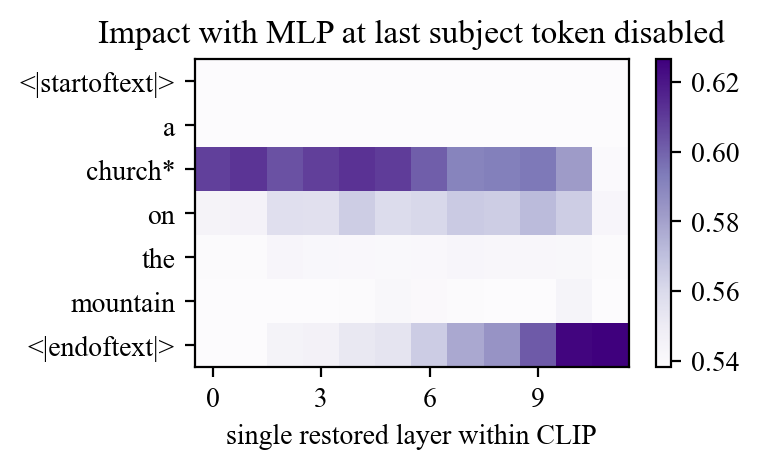

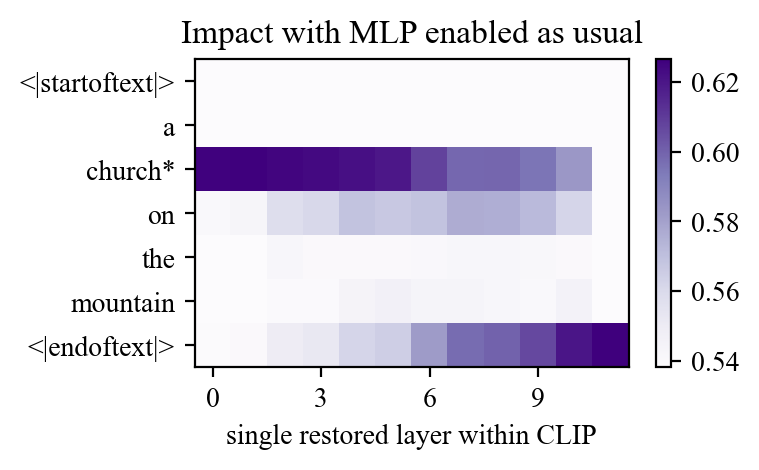

In [11]:
prefix = "A church on the mountain"
entity = 'church'

generate_images = generate_with_seed(sd_pipeline,prefix,seed=42)
no_attn_r = calculate_hidden_flow_3(
    mt, generate_images, prefix, entity, disable_mlp=True, noise=noise_level
)
plot_trace_heatmap(no_attn_r, title="Impact with MLP at last subject token disabled")
ordinary_r = calculate_hidden_flow_3(mt, generate_images, prefix, entity, noise=noise_level)
plot_trace_heatmap(ordinary_r, title="Impact with MLP enabled as usual")

## Comparing the with-MLP/Attn and without-MLP/Attn traces

Plotting on a bar graph makes it easier to see the difference between the causal effects with and without MLP enabled.

In [11]:
def plot_last_subject(mt,sd_pipeline,prefix, entity, token_range="last_subject", savepdf=None):
    ordinary, no_attn, no_mlp = calculate_last_subject(
        mt, sd_pipeline,prefix, entity, token_range=token_range
    )
    plot_comparison(ordinary, no_attn, no_mlp, prefix, savepdf=savepdf)


def calculate_last_subject(mt, sd_pipeline,prefix, entity, cache=None, token_range="last_subject"):
    def load_from_cache(filename):
        try:
            dat = numpy.load(f"{cache}/{filename}")
            return {
                k: v
                if not isinstance(v, numpy.ndarray)
                else str(v)
                if v.dtype.type is numpy.str_
                else torch.from_numpy(v)
                for k, v in dat.items()
            }
        except FileNotFoundError as e:
            return None

    no_attn_r = load_from_cache("no_attn_r.npz")
    uncached_no_attn_r = no_attn_r is None
    no_mlp_r = load_from_cache("no_mlp_r.npz")
    uncached_no_mlp_r = no_mlp_r is None
    ordinary_r = load_from_cache("ordinary.npz")
    uncached_ordinary_r = ordinary_r is None
    if uncached_no_attn_r:
        generate_images = generate_with_seed(sd_pipeline,prefix,seed=42)
        no_attn_r = calculate_hidden_flow_3(
            mt,
            generate_images,
            prefix,
            entity,
            disable_attn=True,
            token_range=token_range,
            noise=noise_level,
        )
        no_mlp_r = calculate_hidden_flow_3(
            mt,
            generate_images,
            prefix,
            entity,
            disable_mlp=True,
            token_range=token_range,
            noise=noise_level,
        )
        ordinary_r = calculate_hidden_flow_3(
            mt, generate_images,prefix, entity, token_range=token_range, noise=noise_level
        )
    def process_v(k,v):
        if k=='high_score' or k=='image_features':
            re = []
            for vi in v:
                re.append(vi.cpu().numpy())
            return re
        else:
            if torch.is_tensor(v):
                return v.cpu().numpy()
            else:
                return v
        
    if cache is not None:
        os.makedirs(cache, exist_ok=True)
        for u, r, filename in [
            (uncached_no_attn_r, no_attn_r, "no_attn_r.npz"),
            (uncached_no_mlp_r, no_mlp_r, "no_mlp_r.npz"),
            (uncached_ordinary_r, ordinary_r, "ordinary.npz"),
        ]:
            if u:
                numpy.savez(
                    f"{cache}/{filename}",
                    **{
                        k: process_v(k,v)
                        for k, v in r.items()
                    },
                )
    if False:
        return (ordinary_r["scores"][0], no_attn_r["scores"][0], no_mlp_r["scores"][0])
    return (
        ordinary_r["scores"][0] - ordinary_r["low_score"],
        no_attn_r["scores"][0] - ordinary_r["low_score"],
        no_mlp_r["scores"][0] - ordinary_r["low_score"],
    )

    # return ordinary_r['scores'][0], no_attn_r['scores'][0]


def plot_comparison(ordinary, no_attn, no_mlp, title, savepdf=None):
    with plt.rc_context(rc={"font.family": "Times New Roman"}):
        import matplotlib.ticker as mtick

        fig, ax = plt.subplots(1, figsize=(6, 3), dpi=300)
        ax.bar(
            [i - 0.3 for i in range(len(ordinary))],
            ordinary,
            width=0.3,
            color="#7261ab",
            label="Impact of single state on P",
        )
        ax.bar(
            [i for i in range(len(no_attn))],
            no_attn,
            width=0.3,
            color="#f3201b",
            label="Impact with Attn severed",
        )
        ax.bar(
            [i + 0.3 for i in range(len(no_mlp))],
            no_mlp,
            width=0.3,
            color="#20b020",
            label="Impact with MLP severed",
        )
        ax.set_title(
            title
        )  #'Impact of individual hidden state at last subject token with MLP disabled')
        ax.set_ylabel("Indirect Effect")
        # ax.set_xlabel('Layer at which the single hidden state is restored')
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        ax.set_ylim(None, max(0.025, ordinary.max() * 1.05))
        ax.legend()
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()


if False:  # Some representative cases.
    plot_last_subject(mt, "Megan Rapinoe plays the sport of", "Megan Rapinoe")
    plot_last_subject(mt, "The Big Bang Theory premires on", "The Big Bang Theory")
    plot_last_subject(mt, "Germaine Greer's domain of work is", "Germaine Greer")
    plot_last_subject(mt, "Brian de Palma works in the area of", "Brian de Palma")
    plot_last_subject(mt, "The headquarter of Zillow is in downtown", "Zillow")
    plot_last_subject(
        mt,
        "Mitsubishi Electric started in the 1900s as a small company in",
        "Mitsubishi",
    )
    plot_last_subject(
        mt,
        "Mitsubishi Electric started in the 1900s as a small company in",
        "Mitsubishi Electric",
    )
    plot_last_subject(mt, "Madame de Montesson died in the city of", "Madame")
    plot_last_subject(
        mt, "Madame de Montesson died in the city of", "Madame de Montesson"
    )
    plot_last_subject(mt, "Edmund Neupert, performing on the", "Edmund Neupert")

tony stark is playing guitar


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

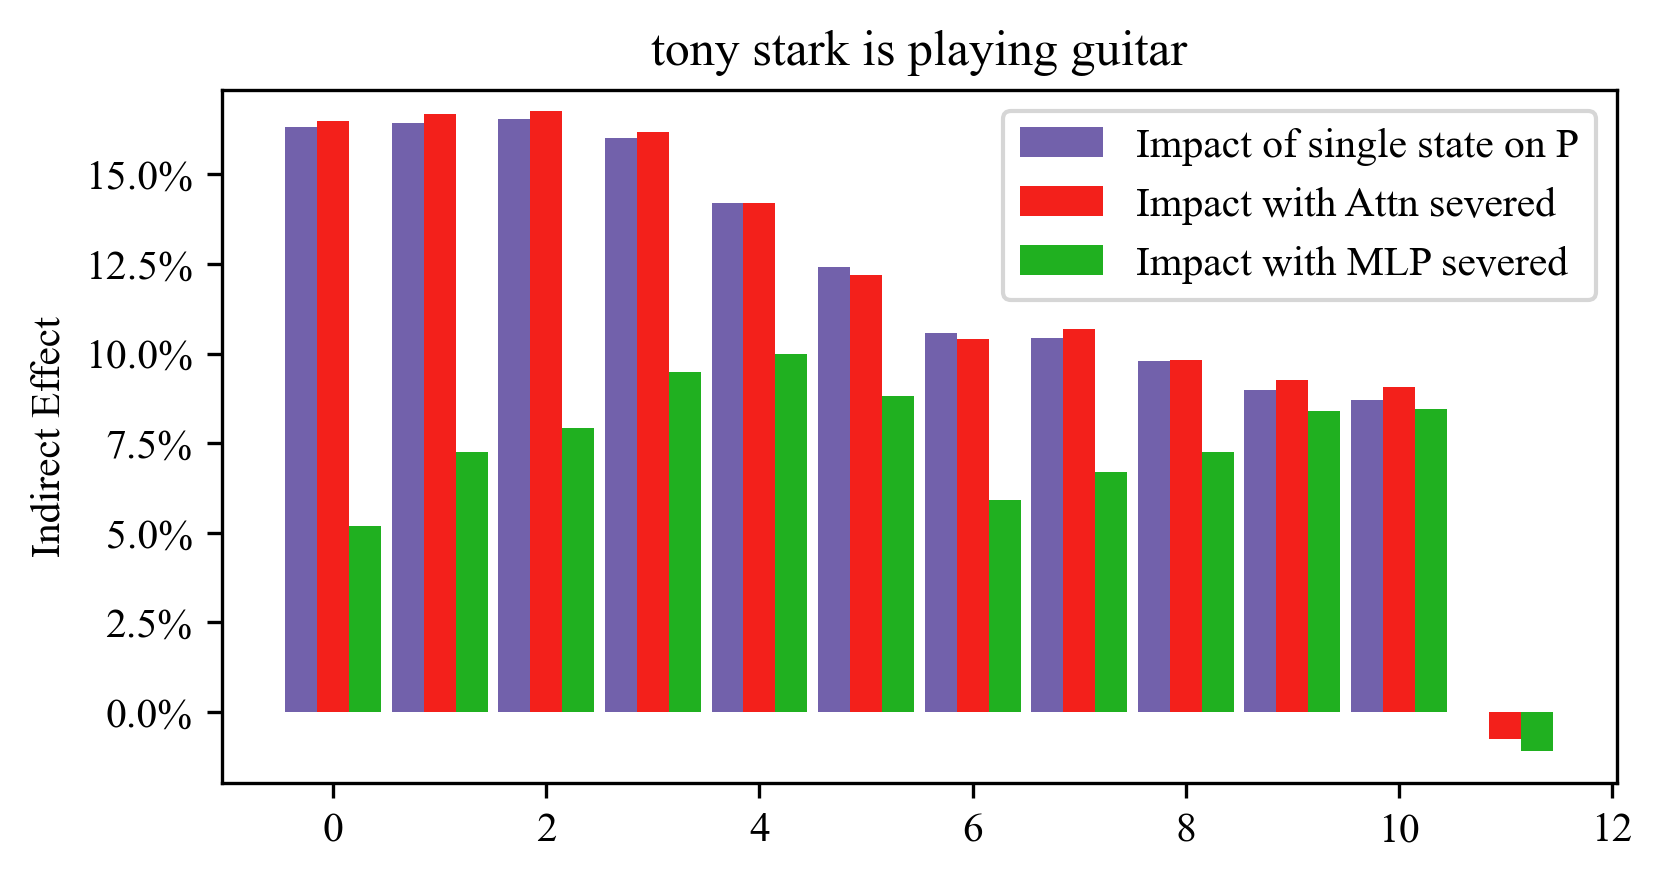

In [13]:
plot_last_subject(mt,sd_pipeline, "tony stark is playing guitar", 'tony stark')

## Average Indirect Effects

Now we average over hundreds of factual statements.

100%|██████████| 500/500 [00:03<00:00, 160.13it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


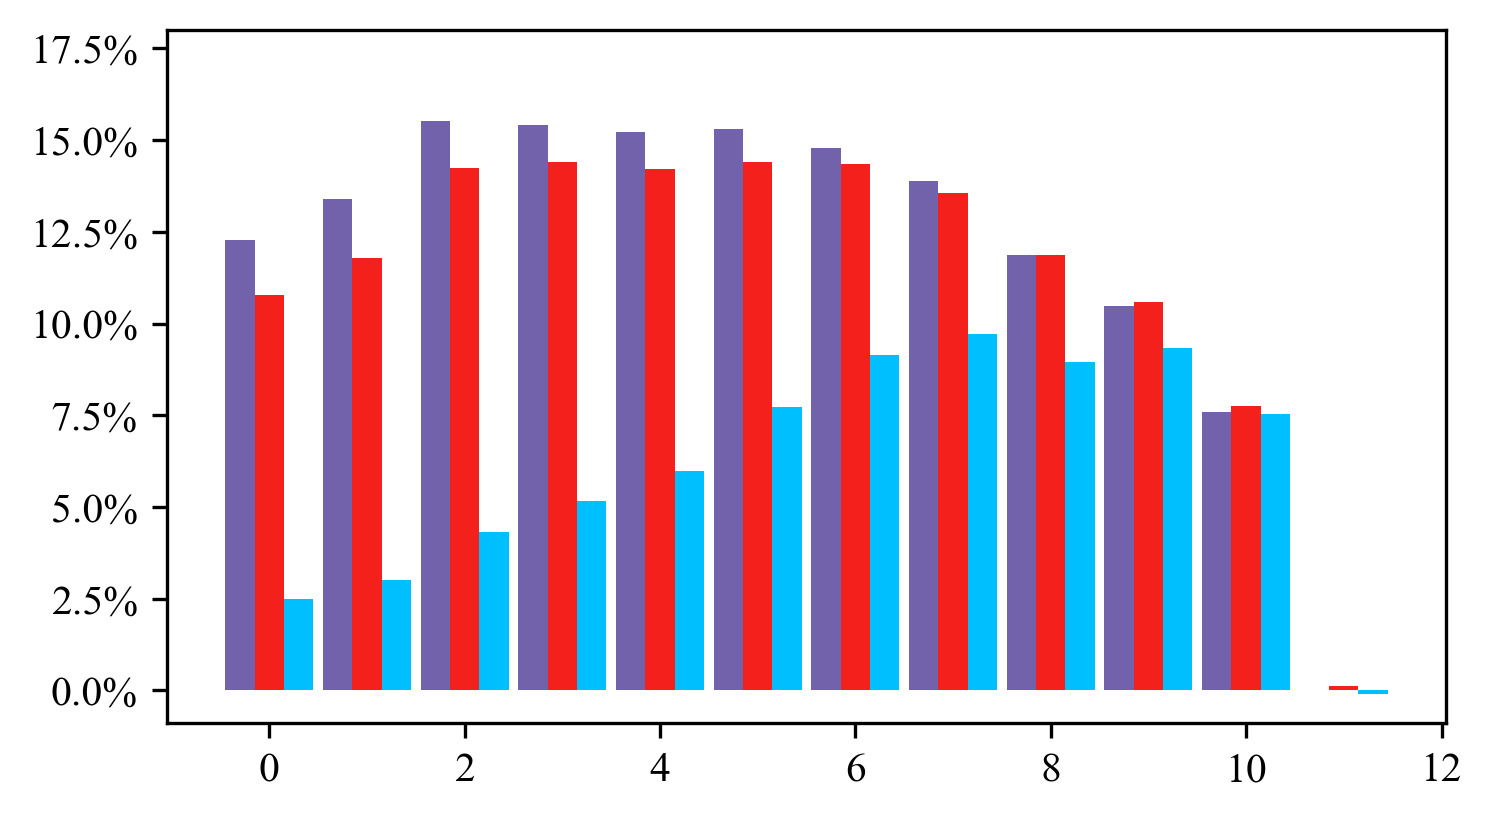

In [19]:
all_ordinary = []
all_no_attn = []
all_no_mlp = []
for i, knowledge in enumerate(tqdm.tqdm(knowns[:500])):
    
    ordinary, no_attn, no_mlp = calculate_last_subject(
        mt,
        sd_pipeline,
        knowledge["prompt"],
        knowledge["artist"],
        cache=f"results/ct_disable_attn/case_{i}",
    )
    all_ordinary.append(ordinary)
    all_no_attn.append(no_attn)
    all_no_mlp.append(no_mlp)
# title = "Causal effect of states at the early site with Attn or MLP modules severed"

avg_ordinary = torch.stack(all_ordinary).mean(dim=0)
avg_no_attn = torch.stack(all_no_attn).mean(dim=0)
avg_no_mlp = torch.stack(all_no_mlp).mean(dim=0)
import matplotlib.ticker as mtick

with plt.rc_context(rc={"font.family": "Times New Roman"}):
    fig, ax = plt.subplots(1, figsize=(5.5, 3), dpi=300)
    ax.bar(
        [i - 0.3 for i in range(12)],
        avg_ordinary,
        width=0.3,
        color="#7261ab",
        # label="Effect of single state on P",
    )
    ax.bar(
        [i for i in range(12)],
        avg_no_attn,
        width=0.3,
        color="#f3201b",
        # label="Effect with Attn severed",
    )
    ax.bar(
        [i + 0.3 for i in range(12)],
        avg_no_mlp,
        width=0.3,
        color="#00bfff",
        # label="Effect with MLP severed",
    )
    # ax.set_title(
    #     title
    # )  #'Impact of individual hidden state at last subject token with MLP disabled')
    # ax.set_ylabel("Average Indirect Effect")
    # ax.set_xlabel("Layer at which the single hidden state is restored")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_ylim(None, max(0.025, ordinary.max() * 1.25, avg_no_attn.max() * 1.25,avg_no_mlp.max() * 1.25))

    ax.legend(frameon=False)
plt.show()